In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
import random

import utilities as ut
import modularised_utils as mut
import evaluation_utils as evut

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

sns.set_theme(style="whitegrid")
seed = 42
np.random.seed(seed)

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [3]:
experiment = 'slc'
path = f"data/{experiment}/results_empirical"
saved_folds = joblib.load(f"data/{experiment}/cv_folds.pkl")

In [4]:
# Load the dictionaries containing the results for each optimization method
diroca_results_empirical = joblib.load(f"{path}/diroca_cv_results_empirical.pkl")
gradca_results_empirical = joblib.load(f"{path}/gradca_cv_results_empirical.pkl")
baryca_results_empirical = joblib.load(f"{path}/baryca_cv_results_empirical.pkl")
abslingam_results_empirical = joblib.load(f"{path}/abslingam_cv_results_empirical.pkl")


print("Successfully loaded results for all optimization methods.")
print(f"  - DIROCA results keys: {list(diroca_results_empirical.keys())}")
print(f"  - GradCA results keys: {list(gradca_results_empirical.keys())}")
print(f"  - BARYCA results keys: {list(baryca_results_empirical.keys())}")
print(f"  - Abs-LiNGAM results keys: {list(abslingam_results_empirical.keys())}")

results_to_evaluate = {}

# --- Add the baseline methods first ---
results_to_evaluate['GradCA'] = gradca_results_empirical
results_to_evaluate['BARYCA'] = baryca_results_empirical
results_to_evaluate['AbsLiNGAM'] = abslingam_results_empirical

# --- Unpack each DIROCA hyperparameter run into its own "method" ---
# First, find all the different DIROCA runs you tested (e.g., 'eps_delta_2', 'eps_delta_4')
# We can find them by looking at the keys in the first fold's results.
if diroca_results_empirical:
    first_fold_key = list(diroca_results_empirical.keys())[0]
    diroca_run_ids = list(diroca_results_empirical[first_fold_key].keys())

    # Now, create a separate entry for each DIROCA run
    for run_id in diroca_run_ids:
        # Create a new, descriptive name for this method, e.g., "DIROCA (eps_delta_8)"
        method_name = f"DIROCA ({run_id})"
        
        # Create a new dictionary that will only contain the results for this specific run_id
        new_diroca_dict = {}
        for fold_key, fold_results in diroca_results_empirical.items():
            # For each fold, just grab the data for the current run_id
            if run_id in fold_results:
                new_diroca_dict[fold_key] = {run_id: fold_results[run_id]}
        
        # Add this new, filtered dictionary to our main evaluation dictionary
        results_to_evaluate[method_name] = new_diroca_dict

print("\nMethods available for evaluation:")
for key in results_to_evaluate.keys():
    print(f"  - {key}")

Successfully loaded results for all optimization methods.
  - DIROCA results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']
  - GradCA results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']
  - BARYCA results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']
  - Abs-LiNGAM results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']

Methods available for evaluation:
  - GradCA
  - BARYCA
  - AbsLiNGAM
  - DIROCA (eps_0.107_delta_0.035)
  - DIROCA (eps_1.0_delta_1.0)
  - DIROCA (eps_2.0_delta_2.0)
  - DIROCA (eps_4.0_delta_4.0)
  - DIROCA (eps_8.0_delta_8.0)


In [5]:
import joblib
import numpy as np
import pandas as pd
import re # Import the regular expression module

# ======================================================================
# 1. Load All Results Files
# ======================================================================
# (This part of your code is correct and remains the same)
diroca_results_empirical = joblib.load(f"{path}/diroca_cv_results_empirical.pkl")
gradca_results_empirical = joblib.load(f"{path}/gradca_cv_results_empirical.pkl")
baryca_results_empirical = joblib.load(f"{path}/baryca_cv_results_empirical.pkl")
abslingam_results_empirical = joblib.load(f"{path}/abslingam_cv_results_empirical.pkl")

all_data = ut.load_all_data(experiment)
print("✅ Successfully loaded all empirical and baseline results.")

# ======================================================================
# 2. Restructure and Relabel the Results
# ======================================================================
results_to_evaluate = {}

# --- Add the standard baseline methods ---
results_to_evaluate['GradCA'] = gradca_results_empirical
results_to_evaluate['BARYCA'] = baryca_results_empirical

# --- Unpack the two Abs-LiNGAM styles into separate methods ---
if abslingam_results_empirical:
    first_fold_key = list(abslingam_results_empirical.keys())[0]
    for style in abslingam_results_empirical[first_fold_key].keys():
        method_name = f"Abs-LiNGAM ({style})"
        new_abslingam_dict = {}
        for fold_key, fold_results in abslingam_results_empirical.items():
            if style in fold_results:
                new_abslingam_dict[fold_key] = {style: fold_results[style]}
        results_to_evaluate[method_name] = new_abslingam_dict

# --- THIS IS THE MODIFIED SECTION for DIROCA ---
# This helper function now creates the simplified labels
def create_diroca_label(run_id):
    """Parses a run_id and creates a simplified label if epsilon and delta are equal."""
    # Use regular expression to find numbers for epsilon and delta
    matches = re.findall(r'(\d+\.?\d*)', run_id)
    if len(matches) == 2:
        eps, delta = matches
        # If they are the same, use the simplified format
        if eps == delta:
            # Handle integer conversion for clean labels like '1' instead of '1.0'
            val = int(float(eps)) if float(eps).is_integer() else float(eps)
            return f"DIROCA (eps_delta_{val})"
    # Otherwise, or if parsing fails, use the full original name
    return f"DIROCA ({run_id})"

# Unpack each DIROCA hyperparameter run with the new, clean label
if diroca_results_empirical:
    first_fold_key = list(diroca_results_empirical.keys())[0]
    for run_id in diroca_results_empirical[first_fold_key].keys():
        method_name = create_diroca_label(run_id) # Use the new helper to create the name
        new_diroca_dict = {}
        for fold_key, fold_results in diroca_results_empirical.items():
            if run_id in fold_results:
                new_diroca_dict[fold_key] = {run_id: fold_results[run_id]}
        results_to_evaluate[method_name] = new_diroca_dict

print("\n✓ Restructured results with simplified labels.")
print("Methods available for evaluation:")
for key in sorted(results_to_evaluate.keys()):
    print(f"  - {key}")

# ======================================================================
# 3. Create the Final LaTeX Label Map (Updated)
# ======================================================================

# This map now uses the new, simplified DIROCA keys
label_map = {
    'DIROCA (eps_0.107_delta_0.035)': r'DiRoCA$_{\epsilon^*, \delta^*}$',
    'DIROCA (eps_delta_1)':           r'DiRoCA$_{1,1}$',
    'DIROCA (eps_delta_2)':           r'DiRoCA$_{2,2}$',
    'DIROCA (eps_delta_4)':           r'DiRoCA$_{4,4}$',
    'DIROCA (eps_delta_8)':           r'DiRoCA$_{8,8}$',
    'GradCA':                         r'GRAD$_{(\tau, \omega)}$',
    'BARYCA':                         r'GRAD$_{\text{bary}}$',
    'Abs-LiNGAM (Perfect)':           r'AbsLin$_{\text{p}}$', 
    'Abs-LiNGAM (Noisy)':             r'AbsLin$_{\text{n}}$'
}

Data loaded for 'slc'.
✅ Successfully loaded all empirical and baseline results.

✓ Restructured results with simplified labels.
Methods available for evaluation:
  - Abs-LiNGAM (Noisy)
  - Abs-LiNGAM (Perfect)
  - BARYCA
  - DIROCA (eps_0.107_delta_0.035)
  - DIROCA (eps_delta_1)
  - DIROCA (eps_delta_2)
  - DIROCA (eps_delta_4)
  - DIROCA (eps_delta_8)
  - GradCA


In [6]:
# Load the original data dictionary
all_data      = ut.load_all_data(experiment)

Dll_samples   = all_data['LLmodel']['data']
Dhl_samples   = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega         = all_data['abstraction_data']['omega']
ll_var_names  = list(all_data['LLmodel']['graph'].nodes())
hl_var_names  = list(all_data['HLmodel']['graph'].nodes())

Data loaded for 'slc'.


In [7]:
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    """
    Calculates the abstraction error directly on the endogenous data samples
    by computing a matrix norm between the transformed LL data and the HL data.
    
    Args:
        T_matrix (np.ndarray): The learned abstraction matrix.
        Dll_test (np.ndarray): The low-level endogenous test samples.
        Dhl_test (np.ndarray): The high-level endogenous test samples.
        metric (str): The distance metric to use (e.g., 'fro', 'l1', 'nuclear').
        
    Returns:
        float: The calculated empirical distance.
    """
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan # Cannot compute error on empty data

    try:
        # 1. Transform the low-level data samples using the learned T matrix
        Dhl_predicted = Dll_test @ T_matrix.T
        
        # 2. Compute the direct distance between the predicted and actual data matrices.
        #    NOTE: We transpose the matrices here to match the expected input
        #          of your original compute_empirical_distance function.
        error = evut.compute_empirical_distance(Dhl_predicted.T, Dhl_test.T, metric)
        
    except Exception as e:
        print(f"  - Warning: Could not compute empirical distance. Error: {e}. Returning NaN.")
        return np.nan

    return error

In [8]:
# def apply_shift(clean_data, shift_config, all_var_names, model_level, seed=None):
#     """
#     Applies a specified contamination, using a dedicated random generator
#     for reproducibility.
#     """
#     # Create a local random number generator from the seed
#     rng = np.random.default_rng(seed)
    
#     shift_type = shift_config.get('type')
#     dist_type = shift_config.get('distribution', 'gaussian')
#     n_samples, n_dims = clean_data.shape

#     level_key = 'll_params' if model_level == 'L' else 'hl_params'
#     params = shift_config.get(level_key, {})
    
#     noise_matrix = np.zeros_like(clean_data)
#     if dist_type == 'gaussian':
#         mu = np.array(params.get('mu', np.zeros(n_dims)))
#         sigma_def = params.get('sigma', np.eye(n_dims))
#         sigma = np.diag(np.array(sigma_def)) if np.array(sigma_def).ndim == 1 else np.array(sigma_def)
#         # Use the local generator
#         noise_matrix = rng.multivariate_normal(mean=mu, cov=sigma, size=n_samples)

#     elif dist_type == 'student-t':
#         df = params.get('df', 3)
#         loc = np.array(params.get('loc', np.zeros(n_dims)))
#         shape_def = params.get('shape', np.eye(n_dims))
#         shape = np.diag(np.array(shape_def)) if np.array(shape_def).ndim == 1 else np.array(shape_def)
#         # scipy.stats can also use a specific random state
#         noise_matrix = stats.multivariate_t.rvs(loc=loc, shape=shape, df=df, size=n_samples, random_state=rng)

#     elif dist_type == 'exponential':
#         scale = params.get('scale', 1.0)
#         # Use the local generator
#         noise_matrix = rng.exponential(scale=scale, size=(n_samples, n_dims))
    
#     final_noise = np.zeros_like(clean_data)
#     vars_to_affect = params.get('apply_to_vars')

#     if vars_to_affect is None:
#         final_noise = noise_matrix
#     else:
#         indices_to_affect = [all_var_names.index(var) for var in vars_to_affect if var in all_var_names]
#         final_noise[:, indices_to_affect] = noise_matrix[:, indices_to_affect]

#     return clean_data + final_noise if shift_type == 'additive' else clean_data * final_noise

In [9]:

def apply_shift(clean_data, shift_config, all_var_names, model_level):
    """
    Applies a specified contamination to the test data.
    - Handles different shift types (additive, multiplicative).
    - Handles different distributions (gaussian, student-t, exponential).
    - Handles selective application to a subset of variables.
    """

    shift_type = shift_config.get('type')
    dist_type  = shift_config.get('distribution', 'gaussian')

    n_samples, n_dims = clean_data.shape

    # Select the correct parameter dictionary for the current model level
    level_key = 'll_params' if model_level == 'L' else 'hl_params'
    params = shift_config.get(level_key, {})
    
    # --- 1. Generate the full noise matrix based on the specified distribution ---
    noise_matrix = np.zeros_like(clean_data)
    if dist_type == 'gaussian':
        mu           = np.array(params.get('mu', np.zeros(n_dims)))
        sigma_def    = params.get('sigma', np.eye(n_dims))
        sigma        = np.diag(np.array(sigma_def)) if np.array(sigma_def).ndim == 1 else np.array(sigma_def)
        noise_matrix = np.random.multivariate_normal(mean=mu, cov=sigma, size=n_samples)

    elif dist_type == 'student-t':
        df           = params.get('df', 3)
        loc          = np.array(params.get('loc', np.zeros(n_dims)))
        shape_def    = params.get('shape', np.eye(n_dims))
        shape        = np.diag(np.array(shape_def)) if np.array(shape_def).ndim == 1 else np.array(shape_def)
        noise_matrix = stats.multivariate_t.rvs(loc=loc, shape=shape, df=df, size=n_samples)

    elif dist_type == 'exponential':
        scale        = params.get('scale', 1.0)
        noise_matrix = np.random.exponential(scale=scale, size=(n_samples, n_dims))
    
    # --- 2. Apply noise selectively if specified ---
    final_noise = np.zeros_like(clean_data)
    vars_to_affect = params.get('apply_to_vars')

    if vars_to_affect is None:
        # If not specified, apply noise to all variables
        final_noise = noise_matrix
    else:
        # If specified, apply noise only to the selected columns
        try:
            indices_to_affect = [all_var_names.index(var) for var in vars_to_affect]
            final_noise[:, indices_to_affect] = noise_matrix[:, indices_to_affect]
        except ValueError as e:
            print(f"Warning: A variable in 'apply_to_vars' not found. Error: {e}")
            return clean_data # Return clean data if there's a config error

    # --- 3. Return the contaminated data ---
    if shift_type == 'additive':
        return clean_data + final_noise
    elif shift_type == 'multiplicative':
        return clean_data * final_noise
    else:
        raise ValueError(f"Unknown shift type: {shift_type}")

In [10]:
# def apply_huber_contamination(clean_data, alpha, shift_config, all_var_names, model_level, seed=None):
#     """
#     Contaminates a dataset using the Huber model with a specific seed for reproducibility.
#     """
#     if not (0 <= alpha <= 1):
#         raise ValueError("Alpha must be between 0 and 1.")
#     if alpha == 0:
#         return clean_data
    
#     # Pass the seed down to the noise generation function
#     noisy_data = apply_shift(clean_data, shift_config, all_var_names, model_level, seed=seed)
    
#     if alpha == 1:
#         return noisy_data
        
#     n_samples = clean_data.shape[0]
#     n_to_contaminate = int(alpha * n_samples)
    
#     # Use a local generator to select which rows to replace
#     rng = np.random.default_rng(seed)
#     indices_to_replace = rng.choice(n_samples, n_to_contaminate, replace=False)
    
#     contaminated_data = clean_data.copy()
#     contaminated_data[indices_to_replace] = noisy_data[indices_to_replace]
    
#     return contaminated_data

In [11]:
def apply_huber_contamination(clean_data, alpha, shift_config, all_var_names, model_level, seed=42):
    """
    Contaminates a dataset using the Huber model. A fraction 'alpha' of the
    samples are replaced with noisy versions.

    Args:
        clean_data (np.ndarray): The original, clean test data samples.
        alpha (float): The fraction of data to contaminate (between 0 and 1).
        shift_config (dict): Configuration defining the noise for the outliers.
        all_var_names (list): List of all variable names for this data.
        model_level (str): 'L' for low-level or 'H' for high-level.
        
    Returns:
        np.ndarray: The new, contaminated test data.
    """
    #np.random.seed(seed)
    if not (0 <= alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    if alpha == 0:
        return clean_data
    
    # Create the fully noisy version of the data using our existing function
    noisy_data = apply_shift(clean_data, shift_config, all_var_names, model_level)
    
    if alpha == 1:
        return noisy_data
        
    n_samples = clean_data.shape[0]
    n_to_contaminate = int(alpha * n_samples)
    
    # Randomly select which rows to replace
    indices_to_replace = np.random.choice(n_samples, n_to_contaminate, replace=False)
    
    # Start with a copy of the clean data
    contaminated_data = clean_data.copy()
    
    # Replace the selected rows with their noisy versions
    contaminated_data[indices_to_replace] = noisy_data[indices_to_replace]
    
    return contaminated_data

In [12]:
alpha_values = np.linspace(0, 1.0, 10) 
noise_levels = np.linspace(0, 5.0, 25)
num_trials = 2
zero_mean = True
base_sigma_L = np.eye(len(all_data['LLmodel']['graph'].nodes()))
base_sigma_H = np.eye(len(all_data['HLmodel']['graph'].nodes()))

evaluation_records = []
for alpha in tqdm(alpha_values, desc="Alpha Levels"):
    for scale in noise_levels:
        for trial in range(num_trials):
            for i, fold_info in enumerate(saved_folds):
                for method_name, results_dict in results_to_evaluate.items():
                    
                    fold_results = results_dict[f'fold_{i}']
                    for run_key, run_data in fold_results.items():
                        
                        T_learned = run_data['T_matrix']
                        test_indices = run_data['test_indices']
                        
                        errors_per_intervention = []
                        for iota in I_ll_relevant:

                            Dll_test_clean = Dll_samples[iota][test_indices]
                            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
                            
                            if zero_mean:
                                mu_scale_L = np.zeros(base_sigma_L.shape[0])
                                mu_scale_H = np.zeros(base_sigma_H.shape[0])
                            else:
                                mu_scale_L = np.ones(base_sigma_L.shape[0])*scale
                                mu_scale_H = np.ones(base_sigma_H.shape[0])*scale
                            
                            sigma_scale_L = base_sigma_L * (scale**2)
                            sigma_scale_H = base_sigma_H * (scale**2)

                            shift_config = {
                                'type': 'additive', 'distribution': 'gaussian',
                                'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
                                'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H}
                            }
                            
                            Dll_test_contaminated = apply_huber_contamination(Dll_test_clean, alpha, shift_config, ll_var_names, 'L', seed=trial)
                            Dhl_test_contaminated = apply_huber_contamination(Dhl_test_clean, alpha, shift_config, hl_var_names, 'H', seed=trial)
                            
                            error = calculate_empirical_error(T_learned, Dll_test_contaminated, Dhl_test_contaminated)
                            if not np.isnan(error):
                                errors_per_intervention.append(error)
                        
                        avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                        
                        record = {
                            'method': method_name,
                            'alpha': alpha,
                            'noise_scale': scale,
                            'trial': trial,
                            'fold': i,
                            'error': avg_error
                        }
                        evaluation_records.append(record)

final_results_df = pd.DataFrame(evaluation_records)

print("--- Full Evaluation Complete ---")

Alpha Levels:   0%|          | 0/10 [00:00<?, ?it/s]

Alpha Levels: 100%|██████████| 10/10 [01:35<00:00,  9.51s/it]

--- Full Evaluation Complete ---


In [13]:
df_clean             = final_results_df[final_results_df['alpha']==0.0]
summary_stats        = df_clean.groupby(['method'])['error'].agg(['mean', 'std', 'count'])
summary_stats['sem'] = summary_stats['std'] / np.sqrt(summary_stats['count'])

print("--- Final Summary (Mean Error ± SEM) ---")

# 2. Now, print the results in your custom table format
print("\n" + "="*65)
print(f"{'Method/Run':<45} | {'Mean Error ± Standard Error of Mean (SEM)'}")
print("="*65)

# The 'method' is now in the index of the summary table
for method_name, row in summary_stats.iterrows():
    mean_val = row['mean']
    sem_val = row['sem']
    
    # The method_name from the index is already the clean display name
    print(f"{method_name:<45} | {mean_val:>7.4f} ± {sem_val:.4f}")

print("="*65)

--- Final Summary (Mean Error ± SEM) ---

Method/Run                                    | Mean Error ± Standard Error of Mean (SEM)
Abs-LiNGAM (Noisy)                            | 91.6719 ± 0.0183
Abs-LiNGAM (Perfect)                          | 89.2868 ± 0.0153
BARYCA                                        | 85.5442 ± 0.0098
DIROCA (eps_0.107_delta_0.035)                | 87.5015 ± 0.0084
DIROCA (eps_delta_1)                          | 64.3450 ± 0.0132
DIROCA (eps_delta_2)                          | 66.4205 ± 0.0152
DIROCA (eps_delta_4)                          | 66.4205 ± 0.0152
DIROCA (eps_delta_8)                          | 66.4205 ± 0.0152
GradCA                                        | 57.1860 ± 0.0098


In [51]:
alpha_point = 1.0
noise_level_point = 5.0

df_point            = final_results_df[(final_results_df['alpha']==alpha_point) & (final_results_df['noise_scale']==noise_level_point)]
summary_stats        = df_point.groupby(['method'])['error'].agg(['mean', 'std', 'count'])
summary_stats['sem'] = summary_stats['std'] / np.sqrt(summary_stats['count'])

print("--- Final Summary (Mean Error ± SEM) ---")

# 2. Now, print the results in your custom table format
print("\n" + "="*65)
print(f"{'Method/Run':<45} | {'Mean Error ± Standard Error of Mean (SEM)'}")
print("="*65)

# The 'method' is now in the index of the summary table
for method_name, row in summary_stats.iterrows():
    mean_val = row['mean']
    sem_val = row['sem']
    
    # The method_name from the index is already the clean display name
    print(f"{method_name:<45} | {mean_val:>7.4f} ± {sem_val:.4f}")

print("="*65)

--- Final Summary (Mean Error ± SEM) ---

Method/Run                                    | Mean Error ± Standard Error of Mean (SEM)
Abs-LiNGAM (Noisy)                            | 640.0643 ± 0.6984
Abs-LiNGAM (Perfect)                          | 678.1005 ± 1.4394
BARYCA                                        | 637.6544 ± 0.9273
DIROCA (eps_0.107_delta_0.035)                | 667.7518 ± 1.3610
DIROCA (eps_delta_1)                          | 419.3231 ± 0.6954
DIROCA (eps_delta_2)                          | 386.5535 ± 0.3723
DIROCA (eps_delta_4)                          | 387.9412 ± 0.8828
DIROCA (eps_delta_8)                          | 387.5590 ± 0.6607
GradCA                                        | 425.0836 ± 0.7776


In [52]:
label_map = {
    'DIROCA (eps_0.107_delta_0.035)': r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$',
    'DIROCA (eps_delta_1)':     r'DiRoCA$_{1,1}$',
    'DIROCA (eps_delta_2)':     r'DiRoCA$_{2,2}$',
    'DIROCA (eps_delta_4)':     r'DiRoCA$_{4,4}$',
    'DIROCA (eps_delta_8)':     r'DiRoCA$_{8,8}$',
    'GradCA':                   r'GRAD$_{(\tau, \omega)}$',
    'BARYCA':                   r'GRAD$_{\text{bary}}$',
    'Abs-LiNGAM (Perfect)':     r'AbsLin$_{\text{p}}$', 
    'Abs-LiNGAM (Noisy)':       r'AbsLin$_{\text{n}}$'
}

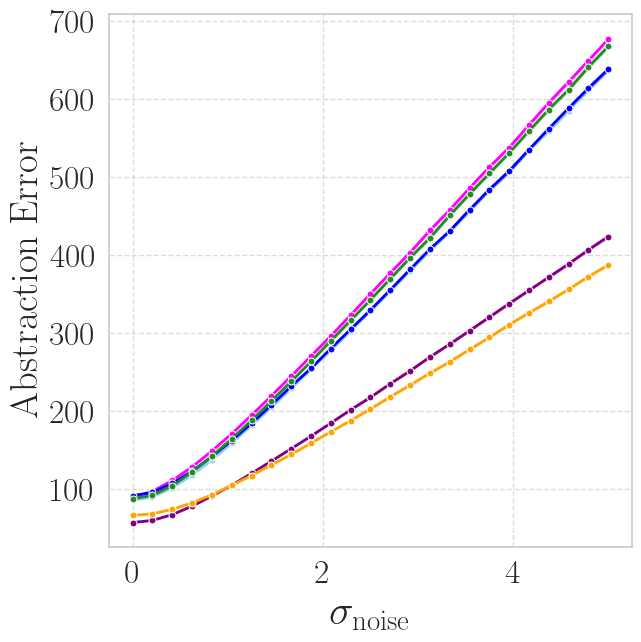

In [57]:
# Define the specific methods you want
methods_to_show = [
    'DIROCA (eps_delta_8)',      # Best DIROCA
    'DIROCA (eps_0.107_delta_0.035)',   # Specific epsilon parameters
    'GradCA',        # AbsLin positive
    'BARYCA',        # AbsLin negative
    'Abs-LiNGAM (Perfect)',      # GRAD
    'Abs-LiNGAM (Noisy)'        # GRAD barycentric
]

alpha_to_plot = 1.0

custom_palette = ['purple', 'lightskyblue', 'magenta', 'blue', 'forestgreen', 'orange']

# Filter for the specific alpha and methods
df_subset = final_results_df[
    (final_results_df['alpha'] == alpha_to_plot) & 
    (final_results_df['method'].isin(methods_to_show))
]

if df_subset.empty:
    print(f"Warning: No data found for alpha ≈ {alpha_to_plot} and the specified methods.")
    print("Available methods for this alpha:")
    print(final_results_df[final_results_df['alpha'] == alpha_to_plot]['method'].unique())
else:
    # Set up LaTeX fonts but disable for legend
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.size': 26,
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 24,
        'ytick.labelsize': 24,
        'legend.fontsize': 20,
        'figure.titlesize': 20
    })
    
    df_for_plotting = df_subset.copy()
    df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)

    plt.figure(figsize=(7, 7))
    sns.lineplot(
        data=df_for_plotting,
        x='noise_scale',
        y='error',
        hue='display_name',
        marker='o',
        linewidth=2,
        markersize=5,
        palette=custom_palette,
        errorbar=('ci', 95),
        legend=False
    )
    #plt.title(r'Robustness to Noise Intensity (at $\alpha = 1.0$)', fontsize=20)
    plt.xlabel(r'$\sigma_{\mathrm{noise}}$', fontsize=30)
    plt.ylabel('Abstraction Error', fontsize=28)
    
    # Get the legend and disable LaTeX for it
    # legend = plt.legend(title='Method', fontsize=16, title_fontsize=18, 
    #                    bbox_to_anchor=(1.05, 1), loc='upper left')
    # For the first plot (noise vs error), replace the legend line with:
    # legend = plt.legend(fontsize=20, 
    #                bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
    
    # # Disable LaTeX for legend text
    # for text in legend.get_texts():
    #     text.set_usetex(False)
    
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

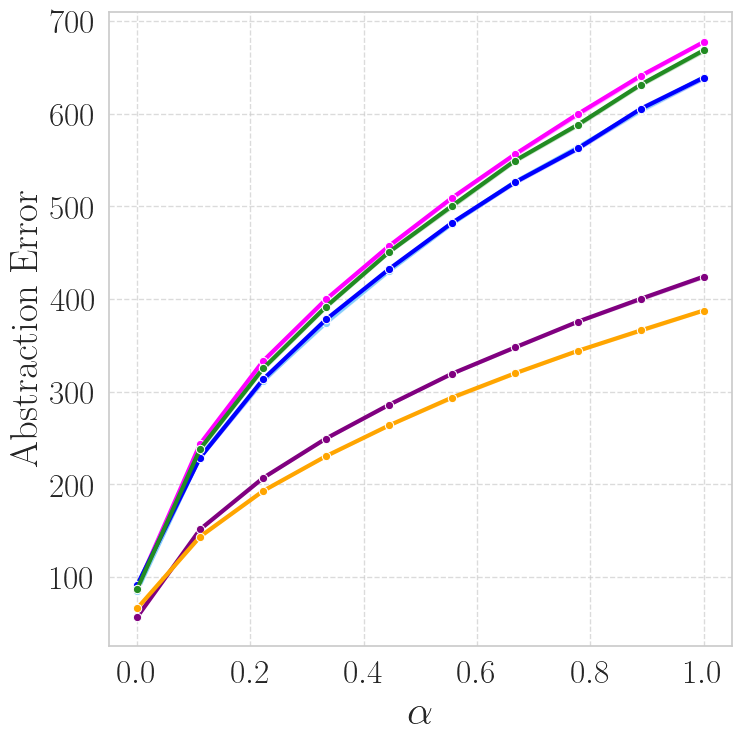

In [55]:
noise_level_to_plot = 5.0

# Define the specific methods you want
methods_to_show = [
    'DIROCA (eps_delta_8)',      # Best DIROCA
    'DIROCA (eps_0.107_delta_0.035)',   # Specific epsilon parameters
    'GradCA',        # AbsLin positive
    'BARYCA',        # AbsLin negative
    'Abs-LiNGAM (Perfect)',      # GRAD
    'Abs-LiNGAM (Noisy)'        # GRAD barycentric
]

custom_palette = ['purple', 'lightskyblue', 'magenta', 'blue', 'forestgreen', 'orange']

# Filter for the specific noise level and methods
df_subset = final_results_df[
    (final_results_df['noise_scale'] == noise_level_to_plot) & 
    (final_results_df['method'].isin(methods_to_show))
]

if df_subset.empty:
    print(f"Warning: No data found for noise_scale ≈ {noise_level_to_plot} and the specified methods.")
    print("Available methods for this noise level:")
    print(final_results_df[final_results_df['noise_scale'] == noise_level_to_plot]['method'].unique())
else:
    # Set up LaTeX fonts but disable for legend
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.size': 26,
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 24,
        'ytick.labelsize': 24,
        'legend.fontsize': 20,
        'figure.titlesize': 20
    })
    
    df_for_plotting = df_subset.copy()
    df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)

    plt.figure(figsize=(8, 8))
    sns.lineplot(
        data=df_for_plotting,
        x='alpha',
        y='error',
        hue='display_name',
        marker='o',
        linewidth=3,
        markersize=6,
        palette=custom_palette,
        errorbar=('ci', 95),
        legend=False
    )

    #plt.title(f'Robustness to Outlier Fraction (at Noise Scale ≈ {noise_level_to_plot})', fontsize=20)
    plt.xlabel(r'$\alpha$', fontsize=30)
    plt.ylabel('Abstraction Error', fontsize=28)
    
    # Legend removed - no legend lines here
    
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [56]:
alpha_values = sorted(final_results_df['alpha'].unique())

df_for_plotting = final_results_df.copy()
df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)


fig, ax = plt.subplots(figsize=(14, 8))
y_max   = final_results_df['error'].max()


def update_alpha(alpha):
    ax.clear() # Clear the previous frame
    
    # Filter the data for the current alpha value
    df_subset = df_for_plotting[np.isclose(df_for_plotting['alpha'], alpha)]
    
    # Draw the lineplot for this frame
    sns.lineplot(
        data=df_subset,
        x='noise_scale',
        y='error',
        hue='display_name',
        marker='o',
        errorbar=('ci', 95),
        ax=ax
    )
    
    ax.set_title(f'Robustness to Noise Intensity (at Alpha = {alpha:.2f})', fontsize=18)
    ax.set_xlabel('Contamination Strength (Noise Scale)', fontsize=14)
    ax.set_ylabel('Average Abstraction Error', fontsize=14)
    ax.legend(title='Method')
    ax.grid(True, which='both', linestyle='--')
    ax.set_ylim(0, y_max * 1.1) # Keep y-axis consistent


print("Creating animation for evolving alpha...")
ani_alpha = FuncAnimation(fig, update_alpha, frames=alpha_values, blit=False, repeat=False)

# Save the GIF
ani_alpha.save('robustness_vs_noise_evolving_alpha.gif', writer='pillow', fps=2)
plt.close() # Prevent the final static plot from showing

print("✓ Animation saved as 'robustness_vs_noise_evolving_alpha.gif'")
# HTML(ani_alpha.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Creating animation for evolving alpha...
✓ Animation saved as 'robustness_vs_noise_evolving_alpha.gif'


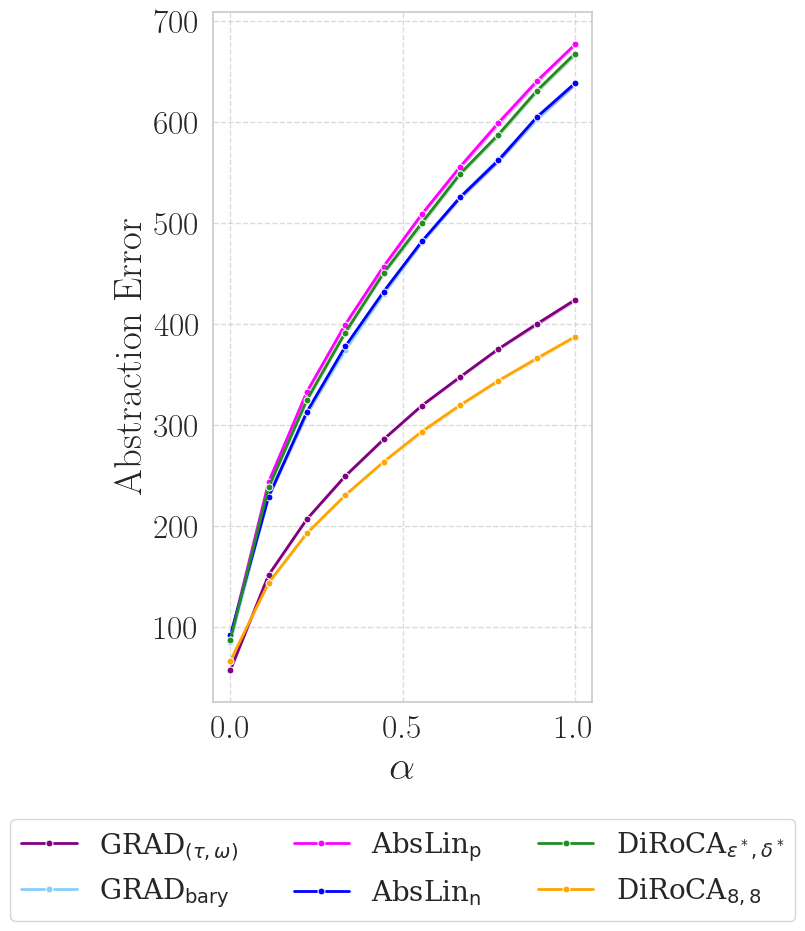

In [49]:
noise_level_to_plot = 5.0

# Define the specific methods you want
methods_to_show = [
    'DIROCA (eps_delta_8)',      # Best DIROCA
    'DIROCA (eps_0.107_delta_0.035)',   # Specific epsilon parameters
    'GradCA',        # AbsLin positive
    'BARYCA',        # AbsLin negative
    'Abs-LiNGAM (Perfect)',      # GRAD
    'Abs-LiNGAM (Noisy)'        # GRAD barycentric
]

custom_palette = ['purple', 'lightskyblue', 'magenta', 'blue', 'forestgreen', 'orange']

# Filter for the specific noise level and methods
df_subset = final_results_df[
    (final_results_df['noise_scale'] == noise_level_to_plot) & 
    (final_results_df['method'].isin(methods_to_show))
]

if df_subset.empty:
    print(f"Warning: No data found for noise_scale ≈ {noise_level_to_plot} and the specified methods.")
    print("Available methods for this noise level:")
    print(final_results_df[final_results_df['noise_scale'] == noise_level_to_plot]['method'].unique())
else:
    # Set up LaTeX fonts but disable for legend
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.size': 26,
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 24,
        'ytick.labelsize': 24,
        'legend.fontsize': 20,
        'figure.titlesize': 20
    })
    
    df_for_plotting = df_subset.copy()
    df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)

    plt.figure(figsize=(7, 10))
    sns.lineplot(
        data=df_for_plotting,
        x='alpha',
        y='error',
        hue='display_name',
        marker='o',
        linewidth=2,
        markersize=5,
        palette=custom_palette,
        errorbar=('ci', 95)
    )

    #plt.title(f'Robustness to Outlier Fraction (at Noise Scale ≈ {noise_level_to_plot})', fontsize=20)
    plt.xlabel(r'$\alpha$', fontsize=30)
    plt.ylabel('Abstraction Error', fontsize=28)
    
    # Get the legend and disable LaTeX for it
    # legend = plt.legend(title='Method', fontsize=16, title_fontsize=18, 
    #                    bbox_to_anchor=(1.05, 1), loc='upper left')
    legend = plt.legend(fontsize=20,
                       bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
    # Disable LaTeX for legend text
    for text in legend.get_texts():
        text.set_usetex(False)
    
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

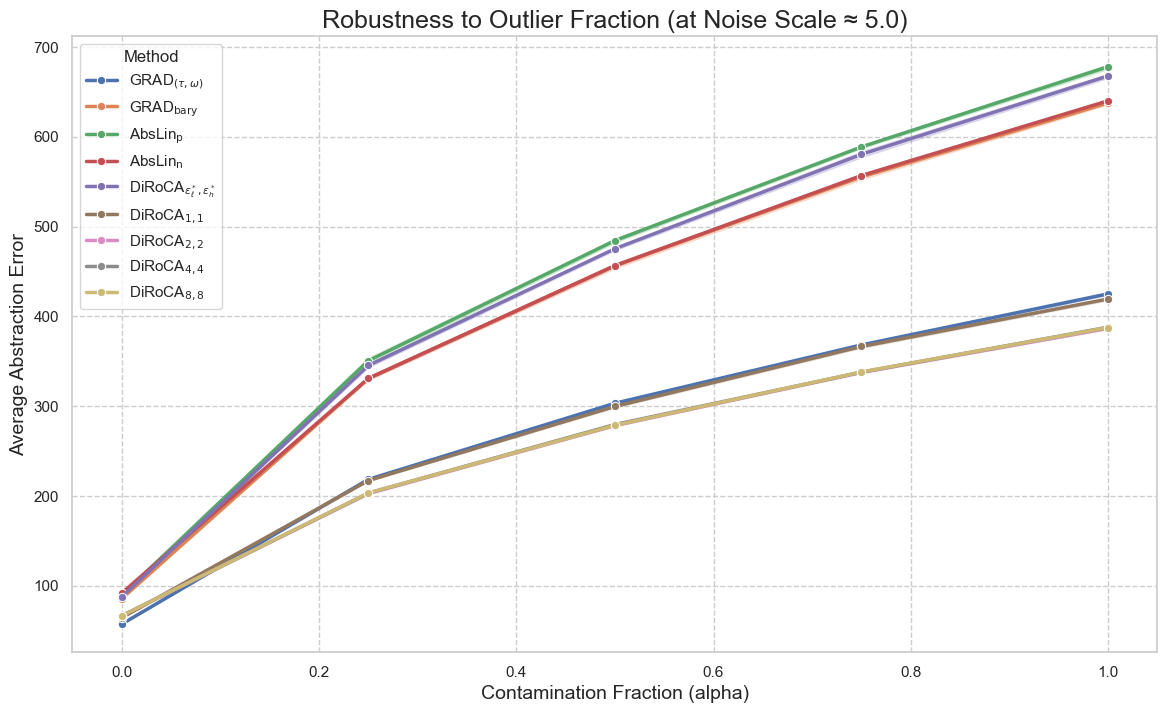

In [57]:
noise_level_to_plot = 5.0

df_subset = final_results_df[final_results_df['noise_scale'] == noise_level_to_plot]

if df_subset.empty:
    print(f"Warning: No data found for noise_scale ≈ {noise_level_to_plot}.")
else:
    df_for_plotting = df_subset.copy()
    df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)

    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=df_for_plotting,
        x='alpha',
        y='error',
        hue='display_name',
        marker='o',
        linewidth=2.5,
        errorbar=('ci', 95)
    )

    plt.title(f'Robustness to Outlier Fraction (at Noise Scale ≈ {noise_level_to_plot})', fontsize=18)
    plt.xlabel('Contamination Fraction (alpha)', fontsize=14)
    plt.ylabel('Average Abstraction Error', fontsize=14)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.show()

In [ ]:
noise_levels = sorted(final_results_df['noise_scale'].unique())

df_for_plotting = final_results_df.copy()
df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)

fig, ax = plt.subplots(figsize=(14, 8))
y_max = final_results_df['error'].max()

def update_noise(scale):
    ax.clear()
    
    # Filter the data for the current noise scale
    df_subset = df_for_plotting[np.isclose(df_for_plotting['noise_scale'], scale)]
    
    # Draw the lineplot for this frame
    sns.lineplot(
        data=df_subset,
        x='alpha',
        y='error',
        hue='display_name',
        marker='o',
        errorbar=('ci', 95),
        ax=ax
    )
    
    ax.set_title(f'Robustness to Outlier Fraction (at Noise Scale ≈ {scale:.2f})', fontsize=18)
    ax.set_xlabel('Contamination Fraction (alpha)', fontsize=14)
    ax.set_ylabel('Average Abstraction Error', fontsize=14)
    ax.legend(title='Method')
    ax.grid(True, which='both', linestyle='--')
    ax.set_ylim(0, y_max * 1.1)


print("Creating animation for evolving noise scale...")
ani_noise = FuncAnimation(fig, update_noise, frames=noise_levels, blit=False, repeat=False)

# Save the GIF
ani_noise.save('robustness_vs_alpha_evolving_noise.gif', writer='pillow', fps=2)
plt.close()

print("✓ Animation saved as 'robustness_vs_alpha_evolving_noise.gif'")
# HTML(ani_noise.to_jshtml())